# Data Reporting 2022: Python Demo

Today, we'll start working with the Python programming language. This notebook gives just a few examples of the type of things you can do with Python to make your reporting better. Don't worry about following along the first time we go through this in class. This is just to show you the possibilities before we jump into some of the basics of the language.


## Installation 
We've already done some installation to get this notebook up and running but you'll want to run the following `pip` commands in a terminal to install the packages we'll need.

```
pip install pandas

pip install pdfplumber

pip install beautifulsoup4

pip install psycopg2
```

## Working with csvs 

In [1]:
import pandas as pd 

df = pd.read_csv('./data/fara.csv')

df.head()

,Registration Number,Registration Date,Name,Business Name,Address 1,Address 2,City,State,Zip
0,7146,07/24/2022,Gas Lamp Market Services & Logistics Group LLC,NaN,209 North Jackson Street,NaN,Monroe,GA,30655
1,7145,07/22/2022,NSW Government US Office Inc.,NaN,150 East 42nd Street 34th Floor,NaN,New York,NY,10017
2,7144,07/22/2022,National Representative council of Eritrea - GIE,NaN,447 Safari Circle,NaN,Stone Mountain,GA,30083
3,7143,07/21/2022,"Slattery, James",NaN,1600 Maddux Lane,NaN,McLean,VA,22101
4,7142,07/19/2022,Vinson & Elkins LLP,NaN,845 Texas Avenue,Suite 4700,Houston,TX,77002


In [2]:
df['City'].value_counts().reset_index().head()

,index,City
0,Washington,178
1,New York,86
2,Los Angeles,12
3,Houston,11
4,Arlington,11


## Working with APIs

Here's an example from the Census API.

In [3]:
import requests

output_path = './data'

fields = [
    'S1501_C01_006E', # Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over
    'S1501_C01_015E', # Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher
]

fields_str = ','.join(fields)

call = ('https://api.census.gov/data/2019/acs/acs5/subject?'
    f'get=NAME,{fields_str}'
    f'&for=county:*')

r = requests.get(call)

data = r.json()

data[:5]

[['NAME', 'S1501_C01_006E', 'S1501_C01_015E', 'state', 'county'],
 ['Lake County, Illinois', '457676', '207440', '17', '097'],
 ['Fayette County, Illinois', '15303', '1727', '17', '051'],
 ['Logan County, Illinois', '20373', '4059', '17', '107'],
 ['Saline County, Illinois', '17113', '3288', '17', '165']]

In [4]:
df = pd.DataFrame(data[1:], columns = data[0])

df.head()

,NAME,S1501_C01_006E,S1501_C01_015E,state,county
0,"Lake County, Illinois",457676,207440,17,097
1,"Fayette County, Illinois",15303,1727,17,051
2,"Logan County, Illinois",20373,4059,17,107
3,"Saline County, Illinois",17113,3288,17,165
4,"Massac County, Illinois",10021,1396,17,127


In [6]:
df['pct_bach_higher'] = round(df['S1501_C01_015E'].astype('int') / df['S1501_C01_006E'].astype('int') * 100, 2)

df = df.sort_values(by=['pct_bach_higher'], ascending=False)

df.head()

,NAME,S1501_C01_006E,S1501_C01_015E,state,county,pct_bach_higher
3146,"Falls Church city, Virginia",9580,7430,51,610,77.56
262,"Arlington County, Virginia",172979,130252,51,013,75.30
1928,"Los Alamos County, New Mexico",13260,8938,35,028,67.41
261,"Alexandria city, Virginia",119631,75483,51,510,63.10
1169,"Howard County, Maryland",215300,134698,24,027,62.56


In [7]:
df['fips'] = df['state'] + df['county']

df.head()

,NAME,S1501_C01_006E,S1501_C01_015E,state,county,pct_bach_higher,fips
3146,"Falls Church city, Virginia",9580,7430,51,610,77.56,51610
262,"Arlington County, Virginia",172979,130252,51,013,75.30,51013
1928,"Los Alamos County, New Mexico",13260,8938,35,028,67.41,35028
261,"Alexandria city, Virginia",119631,75483,51,510,63.10,51510
1169,"Howard County, Maryland",215300,134698,24,027,62.56,24027


## Working with PDFs

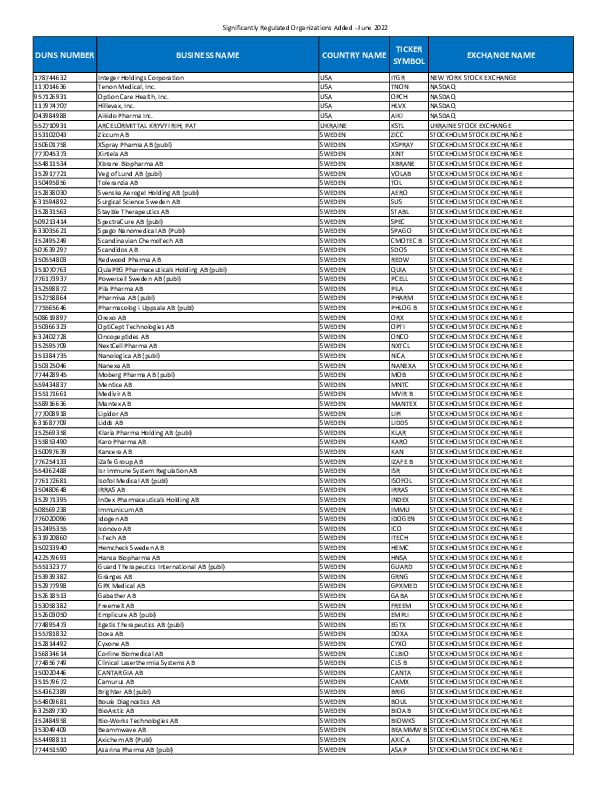

In [8]:
import pdfplumber 

pdf = './data/table.pdf'

p = pdfplumber.open(pdf)

p.pages[0].to_image()

In [9]:
def extract_data(path):
    '''
    Extracts tabular data from each PDF
    '''
    data = []
    with pdfplumber.open(path) as pdf:
        for page in pdf.pages:
            page_data = page.extract_table()
            data.extend(page_data[1:])
    return data



data = extract_data(pdf)

data[:5]

[['178744632',
  'Integer Holdings Corporation',
  'USA',
  'ITGR',
  'NEW YORK STOCK EXCHANGE'],
 ['117014636', 'Tenon Medical, Inc.', 'USA', 'TNON', 'NASDAQ'],
 ['957126931', 'Option Care Health, Inc.', 'USA', 'OPCH', 'NASDAQ'],
 ['117974707', 'Hillevax, Inc.', 'USA', 'HLVX', 'NASDAQ'],
 ['043984988', 'Aikido Pharma Inc.', 'USA', 'AIKI', 'NASDAQ']]

In [10]:
columns = [
    'duns',
    'business_name',
    'country_name',
    'ticker_symbol',
    'exchange'
    ]

df = pd.DataFrame(data, columns = columns)

df.head()

,duns,business_name,country_name,ticker_symbol,exchange
0,178744632,Integer Holdings Corporation,USA,ITGR,NEW YORK STOCK EXCHANGE
1,117014636,"Tenon Medical, Inc.",USA,TNON,NASDAQ
2,957126931,"Option Care Health, Inc.",USA,OPCH,NASDAQ
3,117974707,"Hillevax, Inc.",USA,HLVX,NASDAQ
4,043984988,Aikido Pharma Inc.,USA,AIKI,NASDAQ


## Scraping websites

In [11]:
import time

import requests
from bs4 import BeautifulSoup
import progressbar
import pandas as pd
import re
from bs4 import BeautifulSoup


url = 'http://www.dodig.mil/reports.html/'

def make_soup(url):
    '''
    Input:
        Url
    Output:
        Parsable html
    '''
    html = requests.get(url)
    soup = BeautifulSoup(html.text, "lxml")
    return soup


def get_page_urls(soup):
    '''
    Gets the number of the last page and then generates a list of urls for each page of results.
    Input:
        Page soup
    Output:
        List of result page urls
    '''
    pages = soup.find_all('ul', attrs='pagination')[0]
    p_nums = [int(page.text) for page in pages.find_all('span')]
    urls = [f'http://www.dodig.mil/reports.html/?Page={n}' for n in range(1,max(p_nums)+1)]
    return urls


def parse_reports(urls):
    '''
    Input:
        Result page urls
    Output:
        
    '''
    reports = []
    bar = progressbar.ProgressBar(max_value=len(urls))
    for r_index, url in enumerate(urls):
        soup = make_soup(url)
        results = soup.find_all('div', attrs='alist news')[0]
        for r in results.find_all('div', attrs='info'):
            report = {
                'date': r.find('p', attrs='date').text.strip(),
                'url': r.find('a').get('href'),
                'title': r.find('a').text,
                'description': r.find('p', attrs='hidden-oxs').text.strip()   
                }
            reports.append(report)
        time.sleep(5)
        bar.update(r_index+1)
    return reports

soup = make_soup(url)

page_urls = get_page_urls(soup)

reports = parse_reports(page_urls[:1])

df = pd.DataFrame(reports)

df

N/A% (0 of 1) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

,date,url,title,description
0,"July 22, 2022",http://www.dodig.mil/reports.html/Article/3105...,Evaluation of Efforts by the Office of the Un...,
1,"July 21, 2022",http://www.dodig.mil/reports.html/Article/3103...,Audit of Sole-Source Depot Maintenance Contra...,
2,"July 20, 2022",http://www.dodig.mil/reports.html/Article/3100...,Acting Department of Defense Inspector Genera...,Acting Department of Defense (DoD) Inspector G...
3,"July 18, 2022",http://www.dodig.mil/reports.html/Article/3098...,Project Announcement: Evaluation of the Nucle...,We plan to begin the subject evaluation in Jul...
4,"July 11, 2022",http://www.dodig.mil/reports.html/Article/3091...,Whistleblower Reprisal Investigation: Program...,
5,"July 11, 2022",http://www.dodig.mil/reports.html/Article/3094...,Project Announcement: Evaluation of the Depar...,We plan to begin the subject evaluation in Jul...
6,"July 8, 2022",http://www.dodig.mil/reports.html/Article/3089...,Management Advisory: The DoD’s Use of Ukraine...,
7,"July 7, 2022",http://www.dodig.mil/reports.html/Article/3088...,Audit of Training Ranges in the U.S. European...,This report contains controlled unclassified i...
8,"July 5, 2022",http://www.dodig.mil/reports.html/Article/3090...,Project Announcement: Summary External Peer R...,We will begin the subject evaluation in July 2...
9,"June 29, 2022",http://www.dodig.mil/reports.html/Article/3079...,Project Announcement: Summary Evaluation of S...,We plan to begin the subject evaluation in Jun...


In [12]:
def categorize(row):
    if 'CLASSIFIED' in row['title'].upper():
        return True
    if 'CLASSIFIED' in row['description'].upper():
        return True
    if 'This report is no longer classified' in row['description']:
        return False
    else:
        return False
    
def redacted(row):
    if 'REDACTED' in row['description']:
        return True
    else:
        return False
    
df['title_report_code'] = 'DODIG-' + df['title'].str.findall(r'DODIG-(.*)\d+').str[-1].str.replace(')','')

df['classified'] = df.apply (lambda row: categorize(row), axis=1)

df['redacted_copy_available'] = df.apply (lambda row: redacted(row), axis=1)

df

,date,url,title,description,title_report_code,classified,redacted_copy_available
0,"July 22, 2022",http://www.dodig.mil/reports.html/Article/3105...,Evaluation of Efforts by the Office of the Un...,,DODIG-2022-11,False,False
1,"July 21, 2022",http://www.dodig.mil/reports.html/Article/3103...,Audit of Sole-Source Depot Maintenance Contra...,,DODIG-2022-10,False,False
2,"July 20, 2022",http://www.dodig.mil/reports.html/Article/3100...,Acting Department of Defense Inspector Genera...,Acting Department of Defense (DoD) Inspector G...,NaN,False,False
3,"July 18, 2022",http://www.dodig.mil/reports.html/Article/3098...,Project Announcement: Evaluation of the Nucle...,We plan to begin the subject evaluation in Jul...,NaN,False,False
4,"July 11, 2022",http://www.dodig.mil/reports.html/Article/3091...,Whistleblower Reprisal Investigation: Program...,,DODIG-2022-11,False,False
5,"July 11, 2022",http://www.dodig.mil/reports.html/Article/3094...,Project Announcement: Evaluation of the Depar...,We plan to begin the subject evaluation in Jul...,NaN,False,False
6,"July 8, 2022",http://www.dodig.mil/reports.html/Article/3089...,Management Advisory: The DoD’s Use of Ukraine...,,DODIG-2022-11,False,False
7,"July 7, 2022",http://www.dodig.mil/reports.html/Article/3088...,Audit of Training Ranges in the U.S. European...,This report contains controlled unclassified i...,DODIG-2022-11,True,False
8,"July 5, 2022",http://www.dodig.mil/reports.html/Article/3090...,Project Announcement: Summary External Peer R...,We will begin the subject evaluation in July 2...,NaN,False,False
9,"June 29, 2022",http://www.dodig.mil/reports.html/Article/3079...,Project Announcement: Summary Evaluation of S...,We plan to begin the subject evaluation in Jun...,NaN,False,False


## Automatically draft FOIA requests

In [13]:
dodig_rpts = df.to_dict('records')

foias = []

for d in dodig_rpts:
    if d['title_report_code'] is not None:
        foia_language = f'''
        This is a request under the Freedom of Information Act. 
        I request that copies of the following records be provided to me via email 
        or other electronic means if possible: 
        DODIG reports:\n 
        {d['title_report_code']}, 
        {d['title']}.

        In order to help to determine my status to assess fees, you should know that 
        I am a representative of the news media working as a reporter for 
        The Wall Street Journal and this request is made as part of news gathering 
        and not for a commercial use.
        I am willing to pay fees for this request up to a maximum of $50. If you 
        estimate that the fees will exceed this limit, please inform me first. 
        I request a waiver of all fees for this request. 
        Disclosure of the requested information to me is in the public interest 
        because it is likely to contribute significantly to public understanding 
        of the operations or activities of the government and is not primarily in 
        my commercial interest. The Inspector General’s role is to be a watchdog 
        for the public, guarding against waste, fraud and abuse and informing the 
        public as to its findings. My request is made in furtherance of that goal 
        of public disclosure as I plan to use this document in news coverage.
        Thank you for your consideration of this request.
        --------
        '''
        foias.append(foia_language)
    
print('\n'.join(foias))


        This is a request under the Freedom of Information Act. 
        I request that copies of the following records be provided to me via email 
        or other electronic means if possible: 
        DODIG reports:
 
        DODIG-2022-11, 
         Evaluation of Efforts by the Office of the Under Secretary of Defense for Research and Engineering and Defense Advanced Research Projects Agency to Mitigate Foreign Influence (DODIG-2022-113) .

        In order to help to determine my status to assess fees, you should know that 
        I am a representative of the news media working as a reporter for 
        The Wall Street Journal and this request is made as part of news gathering 
        and not for a commercial use.
        I am willing to pay fees for this request up to a maximum of $50. If you 
        estimate that the fees will exceed this limit, please inform me first. 
        I request a waiver of all fees for this request. 
        Disclosure of the requested informatio

## Working with Databases

In [16]:
import os
from dotenv import dotenv_values
import pathlib

import pandas as pd
import psycopg2 as pg
import pandas.io.sql as psql


def db_connect():
    '''
    Input:
        Args fed via command line; For notebook purposes, we create this locally.
    Output:
        Database connection
    
    '''
    repo_path = pathlib.Path().parent.resolve()
    config = dotenv_values(f'{repo_path}/.env') 
    connection = pg.connect(
            dbname=config['DATABASE'],
            host=config['HOST'],
            password=config['PASSWORD'],
            port=config['PORT'],
            user=config['USER']
    )
    connection.set_session(readonly=True, autocommit=True)
    return connection, connection.cursor()


def read_query(query):
    '''
    Input:
        String of SQL query 
        DB connection
    Return 
        Pandas DataFrame
    '''
    connection, cursor = db_connect()
    df = pd.read_sql_query(query, connection)
    connection.close()
    return df


query = '''
select *
from wh_salaries;
'''

df = read_query(query)

df.head()

,name,status,salary,salary_number,pay_basis,position_title
0,"Abernathy, Nell L.",DETAILEE,"$172,500.00",172500.0,Per Annum,SENIOR POLICY ADVISOR FOR DOMESTIC COMPETITIVE...
1,"Adams, Michelle V.",EMPLOYEE,$0.00,0.0,Per Annum,MEMBER OF THE PRESIDENT'S COMMISSION ON THE SU...
2,"Adiga, Mala",EMPLOYEE,"$155,000.00",155000.0,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND DIRECTOR...
3,"Adkins, William B.",EMPLOYEE,"$53,000.00",53000.0,Per Annum,ASSOCIATE DIRECTOR
4,"Alcorn, Stephonn O.",EMPLOYEE,"$62,500.00",62500.0,Per Annum,ASSOCIATE DIRECTOR FOR RACIAL JUSTICE AND EQUITY


## Data Cleaning

In [17]:
df['salary_number_python'] = df['salary'].str.replace('$', '').str.replace(',', '').astype('float')

df

,name,status,salary,salary_number,pay_basis,position_title,salary_number_python
0,"Abernathy, Nell L.",DETAILEE,"$172,500.00",172500.0,Per Annum,SENIOR POLICY ADVISOR FOR DOMESTIC COMPETITIVE...,172500.0
1,"Adams, Michelle V.",EMPLOYEE,$0.00,0.0,Per Annum,MEMBER OF THE PRESIDENT'S COMMISSION ON THE SU...,0.0
2,"Adiga, Mala",EMPLOYEE,"$155,000.00",155000.0,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND DIRECTOR...,155000.0
3,"Adkins, William B.",EMPLOYEE,"$53,000.00",53000.0,Per Annum,ASSOCIATE DIRECTOR,53000.0
4,"Alcorn, Stephonn O.",EMPLOYEE,"$62,500.00",62500.0,Per Annum,ASSOCIATE DIRECTOR FOR RACIAL JUSTICE AND EQUITY,62500.0
...,...,...,...,...,...,...,...
555,"Yudelson, Alex R.",EMPLOYEE,"$80,000.00",80000.0,Per Annum,DEPUTY EXECUTIVE SECRETARY FOR THE DOMESTIC PO...,80000.0
556,"Zaidi, Ali A.",EMPLOYEE,"$155,000.00",155000.0,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND DEPUTY N...,155000.0
557,"Zients, Jeffrey D.",EMPLOYEE,"$36,000.00",36000.0,Per Annum,COORDINATOR OF THE COVID-19 RESPONSE AND COUNS...,36000.0
558,"Zimmerman, Thomas S.",EMPLOYEE,"$110,000.00",110000.0,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT FOR NATIONA...,110000.0


## Adding categories and sorting

In [18]:
def mark_150k_plus(row):
    if row['salary_number'] > 150000:
        return True
    else:
        return False


df['150k_plus'] = df.apply (lambda row: mark_150k_plus(row), axis=1)

df[df['salary_number_python'] > 150000].sort_values(by=['salary_number'], ascending=False)


,name,status,salary,salary_number,pay_basis,position_title,salary_number_python,150k_plus
169,"Groom, Molly M.",DETAILEE,"$185,656.00",185656.0,Per Annum,POLICY ADVISOR FOR IMMIGRATION,185656.0,True
202,"Hone, Elizabeth A.",DETAILEE,"$183,164.00",183164.0,Per Annum,SENIOR POLICY ADVISOR FOR BROADBAND,183164.0,True
385,"Psaki, Jennifer R.",EMPLOYEE,"$180,000.00",180000.0,Per Annum,ASSISTANT TO THE PRESIDENT AND PRESS SECRETARY,180000.0,True
458,"Sherwood-Randall, Elizabeth D.",EMPLOYEE,"$180,000.00",180000.0,Per Annum,ASSISTANT TO THE PRESIDENT AND HOMELAND SECURI...,180000.0,True
133,"Finer, Jonathan J.",EMPLOYEE,"$180,000.00",180000.0,Per Annum,ASSISTANT TO THE PRESIDENT AND PRINCIPAL DEPUT...,180000.0,True
...,...,...,...,...,...,...,...,...
317,"Montoya, Ryan J.",EMPLOYEE,"$155,000.00",155000.0,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND DIRECTOR...,155000.0,True
325,"Moritsugu, Erika L.",EMPLOYEE,"$155,000.00",155000.0,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND ASIAN AM...,155000.0,True
349,"Olavarria, Esther M.",EMPLOYEE,"$155,000.00",155000.0,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT FOR IMMIGRATION,155000.0,True
556,"Zaidi, Ali A.",EMPLOYEE,"$155,000.00",155000.0,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND DEPUTY N...,155000.0,True


## Making charts

In [20]:
df['salary_number'].value_counts().reset_index()

,index,salary_number
0,62500.0,90
1,80000.0,70
2,48000.0,64
3,100000.0,57
4,110000.0,53
...,...,...
66,57000.0,1
67,69993.0,1
68,168150.0,1
69,87971.0,1


In [19]:
import altair as alt

salary_counts = df['salary_number'].value_counts().reset_index()

salary_counts.columns = ['salary', 'count']

alt.Chart(salary_counts).mark_bar().encode(
    alt.X("salary:Q", bin=True),
    y='count',
)

alt.Chart(...)